In [1]:
import matplotlib.pyplot as plt 
import numpy             as np
import torch
import json
import os
import sys

from torch_geometric.data   import Batch
from torch_geometric.loader import DataLoader
from libraries.model        import nGCNN, eGCNN, diffusion_step, get_graph_losses, add_features_to_graph, predict_noise, diffuse, denoise, EarlyStopping, get_alpha_t
from libraries.dataset      import standardize_dataset, get_datasets

# Checking if pytorch can run in GPU, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
device

device(type='cuda')

In [3]:
# Based on adding and removing noise to graphs
# The models is able to learn hidden patterns
# It can be conditionally trained with respect to some target property
# Although denoising includes noise, I think it is better not to add it when training

In [4]:
# Define name of data folder where reference dataset are contained
# It shall be consistent with data_folder and data will be moved to models folder
data_name = 'MChX'

# Define folder in which data is stored
data_folder = f'data/{data_name}'

# The folder is named as target_folder_vi (eg, target_folder_v0)
general_folder = f'models/{data_name}'
if not os.path.exists(general_folder):
    # Generate new folder
    os.system(f'mkdir {general_folder}')

# Each new run generates a new folder, with different generations and training most likely (as data might vary as well)
i = 0
while True:
    target_folder = f'{general_folder}/GM_v{i}'
    if not os.path.exists(target_folder):
        # Copy all data
        os.system(f'cp -r {data_folder} {target_folder}')
        break
    i += 1

edge_model_name = f'{target_folder}/edge_model.pt'
node_model_name = f'{target_folder}/node_model.pt'
target_folder

'models/MChX/GM_v2'

In [5]:
# Machine-learning parameters
n_epochs      = 2000
batch_size    = 128
learning_rate = 0.0001
patience      = n_epochs
delta         = 0.2
check_labels  = False  # Whether to train-test split attending to labels or not

# Number of diffusing and denoising steps
n_t_steps = 100

# Amount of noise for the generative process
sigma = 0  # Zero for training purposes

# Decay of parameter alpha
noise_contribution = 0.5
alpha_decay = 0.5 * (1 - noise_contribution**2)

# Dropouts for node and edge models (independent of each other)
dropout_node = 0.1
dropout_edge = 0.1

# Create and save as a dictionary
model_parameters = {
    'data_folder':        data_folder,
    'n_epochs':           n_epochs,
    'batch_size':         batch_size,
    'learning_rate':      learning_rate,
    'patience':           patience,
    'delta':              delta,
    'check_labels':       check_labels,
    'n_t_steps':          n_t_steps,
    'sigma':              sigma,
    'noise_contribution': noise_contribution,
    'dropout_node':       dropout_node,
    'dropout_edge':       dropout_edge
}

# Write the dictionary to the file in JSON format
with open(f'{target_folder}/model_parameters.json', 'w') as json_file:
    json.dump(model_parameters, json_file)

# Load of graph database for training

Load the dataset, already standardized.

In [6]:
labels_name                 = f'{target_folder}/labels.pt'
dataset_name                = f'{target_folder}/dataset.pt'
dataset_name_std            = f'{target_folder}/standardized_dataset.pt'
dataset_parameters_name_std = f'{target_folder}/standardized_parameters.json'  # Parameters for rescaling the predictions

if os.path.exists(dataset_name_std) and os.path.exists(dataset_parameters_name_std) and os.path.exists(labels_name):
    # Load the standardized dataset, with corresponding labels and parameters
    dataset = torch.load(dataset_name_std)
    labels  = torch.load(labels_name)
    
    # Load the data from the JSON file
    with open(dataset_parameters_name_std, 'r') as json_file:
        numpy_dict = json.load(json_file)

    # Convert NumPy arrays back to PyTorch tensors
    dataset_parameters = {}
    for key, value in numpy_dict.items():
        try:
            dataset_parameters[key] = torch.tensor(value)
        except:
            dataset_parameters[key] = value

elif os.path.exists(dataset_name) and os.path.exists(labels_name):
    # Load the raw dataset, with corresponding labels, and standardize it
    dataset = torch.load(dataset_name)
    labels  = torch.load(labels_name)
    
    # Standardize dataset
    dataset, dataset_parameters = standardize_dataset(dataset)
    
    # Save standardized dataset
    torch.save(dataset, dataset_name_std)
    
    # Convert torch tensors to numpy arrays
    numpy_dict = {key: value.cpu().numpy().tolist() for key, value in dataset_parameters.items()}

    # Dump the dictionary with numpy arrays to a JSON file
    with open(dataset_parameters_name_std, 'w') as json_file:
        json.dump(numpy_dict, json_file)

else:
    sys.exit('Error: the database is not available')

# Defining target factor
target_factor = dataset_parameters['target_std'] / dataset_parameters['scale']

Split in train, validation and test sets.

In [7]:
train_ratio = 0.9
test_ratio  = 0.05

# Check if data has been already split, else do it randomly
path_to_train_labels = f'{target_folder}/train_labels.txt'
path_to_val_labels   = f'{target_folder}/validation_labels.txt'
path_to_test_labels  = f'{target_folder}/test_labels.txt'

# Copy labels
material_labels = labels.copy()

if os.path.exists(path_to_train_labels) and os.path.exists(path_to_val_labels) and os.path.exists(path_to_test_labels):
    # Read labels splitting (which are strings)
    train_labels = np.genfromtxt(path_to_train_labels, dtype='str').tolist()
    val_labels   = np.genfromtxt(path_to_val_labels,   dtype='str').tolist()
    test_labels  = np.genfromtxt(path_to_test_labels,  dtype='str').tolist()
else:
    if check_labels:
        # Splitting into train-test sets considering that Fvs from the same materials must be in the same dataset
        material_labels = [label.split()[0] for label in material_labels]
        
        # Define unique labels
        unique_labels = np.unique(material_labels)
    else:
        # Completely randomly splitting
        # Copy material_labels
        unique_labels = material_labels.copy()
    
    # Shuffle the list of unique labels
    np.random.shuffle(unique_labels)

    # Define the sizes of the train and test sets
    # Corresponds to the size wrt the number of unique materials in the dataset
    train_size = int(train_ratio * len(unique_labels))
    test_size  = int(test_ratio  * len(unique_labels))
    
    train_labels = unique_labels[:train_size]
    val_labels   = unique_labels[train_size:-test_size]
    test_labels  = unique_labels[-test_size:]

    # Save this splitting for transfer-learning approaches
    np.savetxt(path_to_train_labels, train_labels, fmt='%s')
    np.savetxt(path_to_val_labels,   val_labels,   fmt='%s')
    np.savetxt(path_to_test_labels,  test_labels,  fmt='%s')

# Use the computed indexes to generate train and test sets
# We iteratively check where labels equals a unique train/test labels and append the index to a list
train_dataset = get_datasets(train_labels, material_labels, dataset)
val_dataset   = get_datasets(val_labels,   material_labels, dataset)
test_dataset  = get_datasets(test_labels,  material_labels, dataset)

del dataset  # Free up CUDA memory

print(f'Number of training   graphs: {len(train_dataset)}')
print(f'Number of validation graphs: {len(val_dataset)}')
print(f'Number of testing    graphs: {len(test_dataset)}')

Number of training   graphs: 315
Number of validation graphs: 19
Number of testing    graphs: 17


In [8]:
for graph in train_dataset:
    graph.y = torch.tensor([0], dtype=torch.float)

for graph in val_dataset:
    graph.y = torch.tensor([0], dtype=torch.float)

for graph in test_dataset:
    graph.y = torch.tensor([0], dtype=torch.float)

Define data loaders.

In [9]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=True, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=True, pin_memory=True)

# Determine number of node-level features in dataset
n_node_features = train_dataset[0].num_node_features

# Determine the number of graph-level features to be predicted
n_graph_features = len(train_dataset[0].y)

del train_dataset, val_dataset, test_dataset  # Free up CUDA memory

# Definition of the model

In [10]:
# Instantiate the models for nodes and edges, considering the t_step information; n_graph_features+1 for accounting for the time step
node_model = nGCNN(n_node_features, n_graph_features+1, dropout_node).to(device)
edge_model = eGCNN(n_node_features, n_graph_features+1, dropout_edge).to(device)

# Moving models to device
node_model = node_model.to(device)
edge_model = edge_model.to(device)

# Load previous model if available
try:
    # Load model state
    node_model.load_state_dict(torch.load(node_model_name))
    edge_model.load_state_dict(torch.load(edge_model_name))

    # Evaluate model state
    node_model.eval()
    edge_model.eval()
except FileNotFoundError:
    pass

print('\nNode GCNN:')
print(node_model)
print('\nEdge GCNN:')
print(edge_model)


Node GCNN:
nGCNN(
  (conv1): GraphConv(6, 128)
  (conv2): GraphConv(128, 256)
  (conv3): GraphConv(256, 64)
  (conv4): GraphConv(64, 4)
)

Edge GCNN:
eGCNN(
  (linear1): Linear(in_features=7, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=256, bias=True)
  (linear3): Linear(in_features=256, out_features=64, bias=True)
  (linear4): Linear(in_features=64, out_features=1, bias=True)
)


# Training of the model

# Decay of parameter alpha
alpha_decay = 0.495
t_step = n_t_steps
from libraries.model import get_alpha_t
torch.sqrt(1 - get_alpha_t(t_step, n_t_steps, alpha_decay))

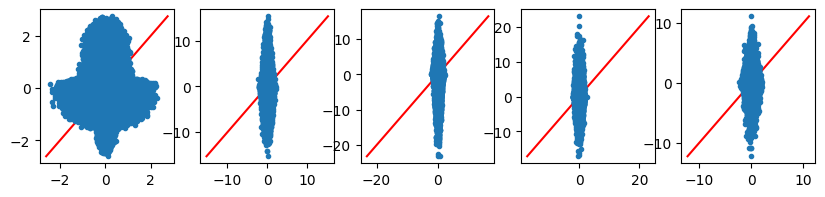

Epoch: 1, edge loss: 16.0363, node loss: 89.1623 116.8299 102.0249 62.8557


In [ ]:
node_attributes_list = ['edge_attr', 'atomic_mass', 'charge', 'electronegativity', 'ionization_energy']

def append_to_dict(dictionary, key, value):
    dictionary[key].append(value.detach().cpu().numpy().tolist())

# Initialize the optimizers
node_optimizer = torch.optim.Adam(node_model.parameters(), lr=learning_rate)
edge_optimizer = torch.optim.Adam(edge_model.parameters(), lr=learning_rate)

# Initialize early stopping
node_early_stopping = EarlyStopping(patience=patience, delta=delta, model_name=node_model_name)
edge_early_stopping = EarlyStopping(patience=patience, delta=delta, model_name=edge_model_name)

# Training loop
edge_train_losses = []
node_train_losses = []
for epoch in range(n_epochs):
    # Initialize train loss variable
    edge_loss_cum = 0
    node_loss_cum = np.zeros(n_node_features, dtype=float)
    ground_truth = {k: [] for k in node_attributes_list}
    prediction   = {k: [] for k in node_attributes_list}

    for batch_0 in train_loader:
        #print()
        # Clone batch of graphs
        g_batch_0 = batch_0.clone()
        
        # Move batch data to GPU
        g_batch_0 = g_batch_0.to(device)
        
        # Read number of graphs in batch
        batch_size_0 = g_batch_0.num_graphs

        # Save graph-level embeddings
        embedding_batch_0 = [g_batch_0[idx].y.detach().to(device) for idx in range(batch_size_0)]
        
        # Initialize the gradient of the optimizers
        node_optimizer.zero_grad()
        edge_optimizer.zero_grad()
        
        # Start denoising-diffusing process
        t_steps = np.arange(1, n_t_steps+1)
        #for t_step in [n_t_steps]:
        for t_step in t_steps:
            # Read time step, which is added to node-level graph embeddings
            # Standard normalization
            t_step_std = torch.tensor([t_step / n_t_steps - 0.5], dtype=torch.float).to(device)
        
            # Diffuse the graph with some noise
            #print()
            #print(f'Step: {t_step}')
            #print('Diffusing...')
            
            g_batch_t = []
            e_batch_t = []
            for idx in range(batch_size_0):
                # Perform a diffusion step at time step t_step for each graph within the batch
                graph_t, epsilon_t = diffusion_step(g_batch_0[idx], t_step, n_t_steps, alpha_decay)
                
                # Append noisy graphs and noises
                g_batch_t.append(graph_t)
                e_batch_t.append(epsilon_t)
        
                # Update diffused graph as next one
                g_batch_0[idx] = graph_t.clone()
            
            # Denoise the diffused graph
            #print(f'Denoising...')
            
            # Add embeddings to noisy graphs (t_step information and graph-level embeddings)
            for idx in range(batch_size_0):
                # Add graph-level embedding to graph_t as node embeddings
                g_batch_t[idx] = add_features_to_graph(g_batch_t[idx],
                                                       embedding_batch_0[idx])  # To match graph.y shape
                
                # Add t_step information to graph_t as node embeddings
                g_batch_t[idx] = add_features_to_graph(g_batch_t[idx],
                                                       t_step_std)  # To match graph.y shape, which is 1D
            
            # Generate batch objects
            g_batch_t = Batch.from_data_list(g_batch_t)
            e_batch_t = Batch.from_data_list(e_batch_t)
            
            # Move data to device
            g_batch_t = g_batch_t.to(device)
            e_batch_t = e_batch_t.to(device)
            
            # Predict batch noise at given time step
            pred_epsilon_t = predict_noise(g_batch_t, node_model, edge_model)

            # Get amount of noise that is added
            alpha_t              = get_alpha_t(t_step, n_t_steps, alpha_decay)
            e_batch_t.x         *= torch.sqrt(1 - alpha_t)
            e_batch_t.edge_attr *= torch.sqrt(1 - alpha_t)

            for key, idx in zip(node_attributes_list, [None, 0, 1, 2, 3]):
                append_to_dict(ground_truth, key,      e_batch_t.edge_attr if idx is None else      e_batch_t.x[:, idx])
                append_to_dict(prediction,   key, pred_epsilon_t.edge_attr if idx is None else pred_epsilon_t.x[:, idx])

            # Backpropagation and optimization step
            #print('Backpropagating...')

            # Calculate the losses for node features and edge attributes
            node_losses, edge_loss = get_graph_losses(e_batch_t, pred_epsilon_t)
            node_losses = [loss * 100 for loss in node_losses]
            edge_loss  *= 100
            
            # Combine losses for each attribute tensors
            node_loss = torch.stack(node_losses).sum()
            
            # Backpropagate and optimize node loss
            if not node_early_stopping.early_stop:
                node_loss.backward(retain_graph=True)
                node_optimizer.step()

            # Backpropagate and optimize edge loss
            if not edge_early_stopping.early_stop:
                edge_loss.backward(retain_graph=True)
                edge_optimizer.step()
            
            # Get items
            node_loss_cum += np.array([node_loss.item() for node_loss in node_losses])
            edge_loss_cum += edge_loss.item()
    
    if not epoch % 10:
        fig, ax = plt.subplots(1, 5, figsize=(10, 2))
        for idx, item in enumerate(ground_truth):
            ground_truth_item = np.concatenate(ground_truth[item])
            prediction_item   = np.concatenate(prediction[item])

            stack = np.concatenate([ground_truth_item, prediction_item])

            _min_ = np.min(stack)
            _max_ = np.max(stack)

            ax[idx].plot([_min_, _max_], [_min_, _max_], '-r')
            ax[idx].plot(ground_truth_item, prediction_item, '.')
        plt.show()

        # Compute the average train loss over n_t_steps
        node_loss_cum /= (n_t_steps * len(train_loader))
        edge_loss_cum /= (n_t_steps * len(train_loader))

        # Append average losses
        node_train_losses.append(node_loss_cum)
        edge_train_losses.append(edge_loss_cum)

        # Check early stopping criteria
        node_early_stopping(node_loss_cum.sum(), node_model)
        edge_early_stopping(edge_loss_cum,       edge_model)

        if node_early_stopping.early_stop and edge_early_stopping.early_stop:
            print('Early stopping')
            break

        print_node_loss = ' '.join([f'{node_loss:.4f}' for node_loss in node_loss_cum])
        print(f'Epoch: {epoch+1}, edge loss: {edge_loss_cum:.4f}, node loss: {print_node_loss}')

In [13]:
rescaled_edge_train_losses = np.sqrt(edge_train_losses) * dataset_parameters['edge_std'].numpy() + dataset_parameters['edge_mean'].numpy()
rescaled_edge_train_losses

array([0.06502617, 0.06318084, 0.06225878, ..., 0.05855323, 0.05854956,
       0.05855115])

In [14]:
node_train_losses = np.array(node_train_losses)
rescaled_node_loss_cum = np.sqrt(node_train_losses) * dataset_parameters['feat_std'].numpy() + dataset_parameters['feat_mean'].numpy()
rescaled_node_loss_cum

array([[161.82681484,  59.82211212,   2.69977255,  10.16168455],
       [160.66459736,  59.28474902,   2.68999432,  10.13634156],
       [159.56437979,  58.80662208,   2.68216234,  10.11541012],
       ...,
       [123.33433301,  50.92399901,   2.46907636,   9.51348666],
       [123.3323141 ,  50.92446452,   2.46911093,   9.51373799],
       [123.33515193,  50.92398577,   2.4691005 ,   9.51348318]])

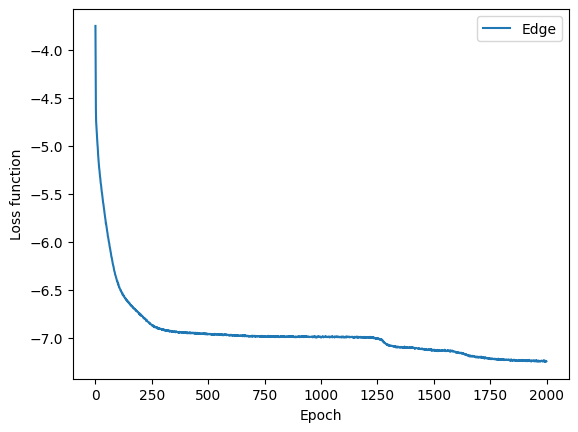

In [15]:
plt.plot(np.log(edge_train_losses), label='Edge')
plt.xlabel('Epoch')
plt.ylabel('Loss function')
plt.legend(loc='best')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


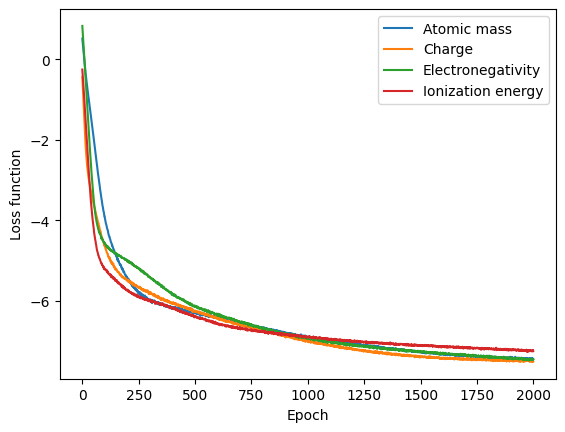

In [16]:
plt.plot(np.log(np.array(node_train_losses)[:, 0]), label=f'Atomic mass')
plt.plot(np.log(np.array(node_train_losses)[:, 1]), label=f'Charge')
plt.plot(np.log(np.array(node_train_losses)[:, 2]), label=f'Electronegativity')
plt.plot(np.log(np.array(node_train_losses)[:, 3]), label=f'Ionization energy')
plt.xlabel('Epoch')
plt.ylabel('Loss function')
plt.legend(loc='best')
plt.savefig('Losses.eps', dpi=50, bbox_inches='tight')
plt.show()

# Test of the model

In [17]:
# Training loop
edge_test_losses = 0
node_test_losses = np.zeros(n_node_features, dtype=float)
idx = 0
for batch_0 in test_loader:
    # Move batch data to GPU
    batch_0 = batch_0.to(device)
    
    # Read number of graphs in batch
    batch_size = batch_0.num_graphs
    
    # Diffuse batch
    g_batch_t = diffuse(batch_0, n_t_steps, s=alpha_decay)
    
    # Denoise batch
    g_batch_0 = denoise(g_batch_t, n_t_steps, node_model, edge_model, n_graph_features,
                        s=alpha_decay, sigma=sigma)
    
    # Calculate the loss for node features and edge attributes
    node_losses, edge_loss = get_graph_losses(batch_0, g_batch_0, batch_size)
    
    # Get items
    edge_loss_cum = edge_loss.item()
    node_loss_cum = np.array([node_loss.item() for node_loss in node_losses])
    
    # Append average losses
    edge_test_losses += edge_loss_cum
    node_test_losses += node_loss_cum
    
    print_node_loss = ' '.join([f'{node_loss:.4f}' for node_loss in node_loss_cum])
    print(f'Batch: {idx}, edge loss: {edge_loss_cum:.4f}, node loss: {print_node_loss}')
    idx += 1

TypeError: get_graph_losses() takes 2 positional arguments but 3 were given

In [ ]:
node_test_losses /= len(test_loader)
edge_test_losses /= len(test_loader)

In [ ]:
edge_test_losses, node_test_losses

# Save results

In [ ]:
# Create and save as a dictionary
model_performance = {
    'edge_train_losses': edge_train_losses,
    'node_train_losses': np.array(node_train_losses).tolist(),
    'edge_test_losses':  edge_test_losses,
    'node_test_losses':  node_test_losses.tolist()
}

# Write the dictionary to the file in JSON format
with open(f'{target_folder}/model_performance.json', 'w') as json_file:
    json.dump(model_performance, json_file)